# Deep Convolution Generative Advarsarial Network

Here is presented the implementation of the following parper https://arxiv.org/abs/1511.06434

Implementation is done in tensorflow using layers API

Created by: Tiago Almeida 05/02/2018


In [1]:
##### imports
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import utils as ut # auxiliar file to help in data visualization

#tensorflow version when notebook was created - 1.4.0
tf.__version__


'1.4.0'

### Data mnist

Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz


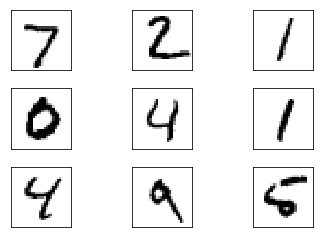

In [2]:


mnist_flat_size = 784

#mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data",one_hot=True)

ut.plot_mnist_images(mnist.test.images[0:9])

### Code parameters

For the architecture of the generator and the discriminator i am gonna try keep loyal to the network on the paper.



In [3]:
z_dimention = 100
mnist_flat_size = 784

batch_size = 64
epoach = 50000

### Generator network

* 2 Deconvolution layers
* No pooling layers
* Batch normalization after convolution and before activation
* Relu and tanh for output 

Note: I want that my final image have dimention $28 = 7\times2\times2$, so i can start with 7x7 image and upscale it by deconvolutions operations (with stride 2x2 and padding the image with zeros) the result would be a image with 14x14 and doing the same upscaling i get the final image with the size 28x28 (same as mnist :D)

In [4]:


Z = tf.placeholder(tf.float32, shape=[None, z_dimention], name='x_generator_input')
Y = tf.placeholder(tf.float32, shape=[None, 10], name='label_oneHot')
isTraining = tf.placeholder_with_default(False, shape=(), name='trainingPhase')

def generator(x,train,name):
    '''
    Generator implemented as MLP
    
    :param x: tensor with shape (M,100) here M = number of samples
    :param train: boolean tensor with indication if we are training or not
    :return: tensor with shape (M,28,28,1) corresponding to the image (28x28) mapping between x and data distribution (pData)
    '''
    with tf.variable_scope("generator",reuse=tf.AUTO_REUSE):
        
        # 1 fully connected layer to get 7x7x64 output (3136)
        fc1 = tf.layers.dense(x, 7*7*64,name="fc1_"+name)
        fc1_bn = tf.layers.batch_normalization(fc1, training=train, name="fc1_bn_"+name)
        fc_relu1 = tf.nn.relu(fc1_bn,name="fc1_fn_"+name)
        
        #reshape
        r = tf.reshape(fc_relu1, [-1, 7, 7, 64])
        
        # 1 deconv 64 filters output 14x14x32
        deconv1 = tf.layers.conv2d_transpose(r, 64, kernel_size=(5, 5), strides=(2, 2)
                                             ,padding='same',name="dconv1_"+name)
        deconv1_bn = tf.layers.batch_normalization(deconv1, training=train,name="dconv1_bn_"+name)
        dc_relu2 = tf.nn.relu(deconv1_bn,name="dconv1_fn_"+name)

        # 2 deconv 1 filters and output 28x28x1
        deconv2 = tf.layers.conv2d_transpose(dc_relu2, 1, kernel_size=(5, 5), strides=(2, 2),padding='same'
                                             ,name="dconv2_"+name, activation=tf.nn.tanh)

        return deconv2



### Discriminator Network
* Leaky relu (alpha 0.2 tensorflow default) and tanh for output 

In [5]:

X = tf.placeholder(tf.float32, shape=[None, mnist_flat_size], name='x_discriminator_input')

def discriminator(x,train,name,drop_rate=0.5):
    '''
    Discriminator implemented as MLP
    
    :param x: tensor with shape (M,784) here M = number of samples
    :return: tensor with shape (M,1) corresponding to the probability of each sample being true or fake
    '''
    with tf.variable_scope("discriminator",reuse=tf.AUTO_REUSE):
        
        #reshape
        r = tf.reshape(x, [-1, 28, 28, 1])
        
        # 1 conv 64 filters output 14x14x32
        conv1 = tf.layers.conv2d(r, 64, kernel_size=(5, 5), strides=(2, 2)
                                             ,padding='same',name="conv1_"+name)
        conv1_bn = tf.layers.batch_normalization(conv1, training=train, name="conv1_bn_"+name)
        c_lrelu1 = tf.nn.leaky_relu(conv1_bn,name="conv1_fn_"+name)
        
        # 2 conv 32 filters and output 7x7x32
        conv2 = tf.layers.conv2d(c_lrelu1, 32, kernel_size=(5, 5), strides=(2, 2),padding='same'
                                             ,name="conv2_"+name)
        conv2_bn = tf.layers.batch_normalization(conv2, training=train, name="conv2_bn_"+name)
        c_relu2 = tf.nn.relu(conv2_bn, name="conv2_fn_"+name)
        
        #flatten
        flatten = tf.layers.flatten(c_relu2)
        
        fc1 = tf.layers.dense(flatten, 7*7*32,name="fc1_"+name,activation=tf.nn.relu)
        fc1_drop = tf.layers.dropout(fc1,rate = drop_rate, training=train)
        
        fc2 = tf.layers.dense(fc1_drop, 256,name="fc2_"+name,activation=tf.nn.relu)
        fc2_drop = tf.layers.dropout(fc2,rate = drop_rate, training=train)
        
        fc3 = tf.layers.dense(fc2_drop, 1,name="fc3_"+name, activation=None)
        
        sig_fc3 = tf.nn.sigmoid(fc3)
        
        return sig_fc3,fc3

    

### Loss functions

In [6]:
#using now the xentropy (TODO use the default)
generated_sample = generator(Z,isTraining,"g_")
d_fake_prob, d_fake_logits = discriminator(generated_sample,isTraining,"d_")

#normalize between -1 1, perhaps more effecient to cache the results or pre process
X_tanh_normalize = (X-0.5)*2
d_true_prob, d_true_logits = discriminator(X_tanh_normalize,isTraining,"d_")

alternative_loss = True

print(d_true_logits)
print(d_fake_logits)
print(generated_sample)
#try avoid log(0)
eps = 1e-8

def xentropy_sigmoid(logits,labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))

with tf.name_scope("discriminator_loss"):
    if alternative_loss:
        d_loss = xentropy_sigmoid(d_true_logits,tf.ones_like(d_true_logits)) + xentropy_sigmoid(d_fake_logits,tf.zeros_like(d_fake_logits)) 
    else:
        d_loss = -tf.reduce_mean(tf.log(d_true_prob + eps) + tf.log(1. - d_fake_prob + eps))


with tf.name_scope("generator_loss"):
    if alternative_loss:
        g_loss = xentropy_sigmoid(d_fake_logits, tf.ones_like(d_fake_logits))
    else:
        g_loss = -tf.reduce_mean(tf.log(d_fake_prob + eps))
    
    

Tensor("discriminator_1/fc3_d_/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("discriminator/fc3_d_/BiasAdd:0", shape=(?, 1), dtype=float32)
Tensor("generator/dconv2_g_/Tanh:0", shape=(?, 28, 28, 1), dtype=float32)


### Geting the trainable variables for generator and the discriminator (disadvantage of using layers API)

In [ ]:
generator_variables = [var for var in tf.trainable_variables() if 'g_' in var.name]
discriminator_variables = [var for var in tf.trainable_variables() if ('d_' in var.name or 'c_' in var.name)]

# kernel = weight
print(generator_variables)
print(discriminator_variables)

[<tf.Variable 'generator/fc1_g_/kernel:0' shape=(100, 3136) dtype=float32_ref>, <tf.Variable 'generator/fc1_g_/bias:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'generator/fc1_bn_g_/gamma:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'generator/fc1_bn_g_/beta:0' shape=(3136,) dtype=float32_ref>, <tf.Variable 'generator/dconv1_g_/kernel:0' shape=(5, 5, 64, 64) dtype=float32_ref>, <tf.Variable 'generator/dconv1_g_/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'generator/dconv1_bn_g_/gamma:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'generator/dconv1_bn_g_/beta:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'generator/dconv2_g_/kernel:0' shape=(5, 5, 1, 64) dtype=float32_ref>, <tf.Variable 'generator/dconv2_g_/bias:0' shape=(1,) dtype=float32_ref>]
[<tf.Variable 'discriminator/conv1_d_/kernel:0' shape=(5, 5, 1, 64) dtype=float32_ref>, <tf.Variable 'discriminator/conv1_d_/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'discriminator/conv1_bn_d_/gamma:0' shape=(64

### Train

Epoach 0
Discriminator loss:  1.72759
Generator loss: 0.991346
(9, 100)
[-0.00274741 -0.00485369 -0.01137832  0.01062992 -0.00793959  0.01188394
 -0.01241731  0.00459272 -0.00187043  0.00091199 -0.00096766  0.01076183
 -0.00322718 -0.00175297 -0.01601115  0.00633341 -0.00606045  0.0053882
 -0.01113958 -0.00481914 -0.00387466 -0.00615809 -0.01629048 -0.00656337
 -0.01736991  0.00287224  0.00292484  0.00858683 -0.00724476  0.00075709
 -0.00976148  0.00532047 -0.02595545 -0.0107182  -0.01120383  0.00614435
 -0.01192655 -0.04051291 -0.01836659 -0.02009371 -0.00050341 -0.00727612
 -0.01090803  0.00023273 -0.01324137 -0.01462677 -0.01018341 -0.03144533
 -0.0006764  -0.01897121 -0.00240271  0.02173019 -0.02871595 -0.00990444
 -0.02309201 -0.01069009 -0.01592874 -0.00074701 -0.01777194  0.01846956
 -0.01197325 -0.01114269 -0.02089643 -0.00975145 -0.03966362  0.01112175
 -0.02644915 -0.00846674  0.00502409  0.00586293 -0.02651063  0.03469592
 -0.01202122  0.01276846 -0.00697151  0.0140943  -0.0

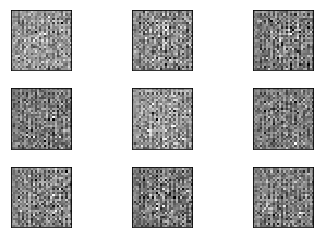

Epoach 500
Discriminator loss:  0.620596
Generator loss: 2.7947
(9, 100)
[-0.1819303  -0.23466001 -0.27999464 -0.26978049 -0.26889008 -0.25755891
 -0.24389811 -0.24896237 -0.2704699  -0.25776026 -0.26424786 -0.27419198
 -0.29052743 -0.23806141 -0.24121742 -0.25524661 -0.26175651 -0.23775561
 -0.28069851 -0.28961393 -0.28232166 -0.30352825 -0.29544464 -0.32321042
 -0.30051896 -0.28440943 -0.28050125 -0.22007906 -0.256551   -0.3170346
 -0.35513502 -0.32954964 -0.35366422 -0.3294982  -0.34990513 -0.36447635
 -0.34750685 -0.30314279 -0.34481797 -0.35082653 -0.3578043  -0.25230896
 -0.31596208 -0.29092398 -0.31429213 -0.26202983 -0.31328002 -0.31354108
 -0.37645623 -0.43842316 -0.44744179 -0.45022309 -0.42103514 -0.34066972
 -0.38368702 -0.31378669 -0.2808646  -0.3612515  -0.3888253  -0.35064501
 -0.35127518 -0.40253165 -0.41812533 -0.39387619 -0.35728788 -0.38246325
 -0.4193702  -0.43274125 -0.39394882 -0.34545037 -0.3299408  -0.28898793
 -0.3148616  -0.3083429  -0.28690502 -0.34202117 -0.

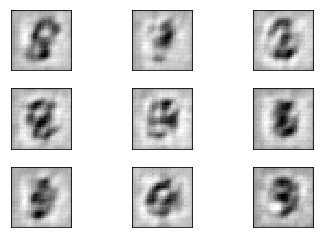

Epoach 1000
Discriminator loss:  0.615825
Generator loss: 2.00118
(9, 100)
[ -3.81068379e-01  -4.64765400e-01  -5.09115696e-01  -4.56864893e-01
  -4.53794360e-01  -4.76226389e-01  -4.81075734e-01  -4.51305330e-01
  -4.81135875e-01  -4.76771563e-01  -4.95718598e-01  -4.89990890e-01
  -4.64310318e-01  -5.01163363e-01  -5.40227592e-01  -5.58635175e-01
  -5.75637758e-01  -6.10623837e-01  -5.62253237e-01  -5.55999994e-01
  -5.20374656e-01  -5.00061572e-01  -4.91650164e-01  -5.12298465e-01
  -5.15574098e-01  -5.07848859e-01  -5.20375252e-01  -4.11723763e-01
  -4.78373170e-01  -5.36722422e-01  -6.07055902e-01  -5.01838565e-01
  -5.24702847e-01  -5.44851184e-01  -6.05562031e-01  -5.41487396e-01
  -5.34191012e-01  -5.47774136e-01  -5.97715139e-01  -5.82653284e-01
  -5.87957501e-01  -5.65051675e-01  -6.42091870e-01  -6.70329690e-01
  -6.94741130e-01  -6.53123021e-01  -6.65687799e-01  -5.98710835e-01
  -5.82171917e-01  -5.49636483e-01  -6.25200272e-01  -5.91766894e-01
  -6.03562593e-01  -5.860049

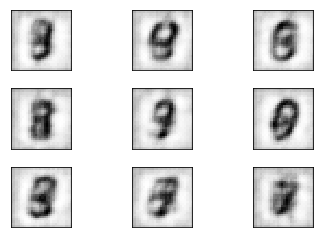

Epoach 1500
Discriminator loss:  0.675934
Generator loss: 3.07739
(9, 100)
[-0.4216868  -0.49232906 -0.6054728  -0.55302107 -0.61368549 -0.64187568
 -0.6515981  -0.60098624 -0.65453029 -0.66453373 -0.65587121 -0.6180554
 -0.63868296 -0.5858748  -0.55334014 -0.52357346 -0.55955732 -0.57508326
 -0.62332821 -0.61478758 -0.66964865 -0.62138075 -0.61713243 -0.58643717
 -0.61175334 -0.5661006  -0.59385943 -0.45340493 -0.53807873 -0.54379153
 -0.6694268  -0.59642899 -0.68563724 -0.70027065 -0.75640917 -0.69057107
 -0.76183474 -0.75853342 -0.77038771 -0.71088237 -0.72814381 -0.63522959
 -0.6204831  -0.55347252 -0.62831569 -0.5571968  -0.64922488 -0.6625948
 -0.75525737 -0.70334727 -0.72864121 -0.68678677 -0.69532681 -0.62011766
 -0.66272092 -0.51694012 -0.6120618  -0.65287328 -0.73868984 -0.71361709
 -0.7869879  -0.8467418  -0.86352271 -0.84830904 -0.87056279 -0.88230288
 -0.87345994 -0.84270799 -0.80939597 -0.74091697 -0.76392794 -0.69478071
 -0.68977714 -0.65104508 -0.75360811 -0.80970132 -0

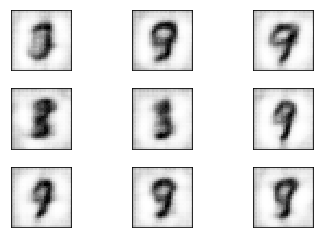

Epoach 2000
Discriminator loss:  0.712943
Generator loss: 2.02719
(9, 100)
[ -4.82664704e-01  -5.74060798e-01  -7.29583263e-01  -6.35321856e-01
  -7.07347333e-01  -6.35240912e-01  -6.79260373e-01  -6.08672976e-01
  -6.90088868e-01  -6.41130209e-01  -6.75327301e-01  -5.99222183e-01
  -6.45616889e-01  -6.20009780e-01  -7.00231791e-01  -7.15366066e-01
  -8.07034612e-01  -7.73617744e-01  -8.03487659e-01  -7.35443234e-01
  -7.70811439e-01  -7.22797453e-01  -7.41442800e-01  -6.66345000e-01
  -6.83700085e-01  -6.05776966e-01  -6.32835031e-01  -4.52568054e-01
  -6.08229995e-01  -7.03346133e-01  -8.15584898e-01  -7.49709070e-01
  -8.02691281e-01  -7.78476834e-01  -8.22624266e-01  -7.85918176e-01
  -8.25850904e-01  -7.87054062e-01  -7.75704622e-01  -7.22799420e-01
  -7.63961792e-01  -6.86927676e-01  -7.59472847e-01  -7.96970546e-01
  -8.88887465e-01  -8.54539096e-01  -8.68593335e-01  -8.17735136e-01
  -8.73513997e-01  -8.32291603e-01  -8.39021206e-01  -7.84391165e-01
  -7.91629791e-01  -7.550737

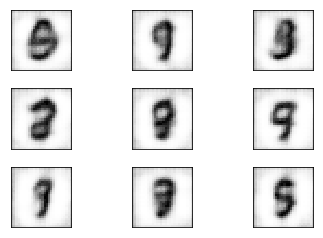

Epoach 2500
Discriminator loss:  0.57479
Generator loss: 1.86197
(9, 100)
[ -4.96591568e-01  -5.56731820e-01  -7.33353972e-01  -6.67998672e-01
  -7.17542946e-01  -6.69569194e-01  -7.31955051e-01  -6.75242424e-01
  -7.79804230e-01  -7.34621644e-01  -8.03019822e-01  -7.62765884e-01
  -7.97608137e-01  -7.66292691e-01  -8.01935315e-01  -7.88378417e-01
  -8.29405963e-01  -7.94122159e-01  -8.12315345e-01  -7.61748433e-01
  -8.17383826e-01  -7.42847800e-01  -7.65252113e-01  -6.83640718e-01
  -6.93247676e-01  -5.91735840e-01  -6.69658780e-01  -5.04864097e-01
  -6.33365393e-01  -7.07014382e-01  -8.35033596e-01  -8.00373971e-01
  -8.35546672e-01  -8.31999958e-01  -8.55582714e-01  -8.38083446e-01
  -8.82296503e-01  -8.65747869e-01  -8.84735048e-01  -8.66957545e-01
  -8.87154996e-01  -8.56678843e-01  -8.73769701e-01  -8.85670066e-01
  -9.32337403e-01  -9.14782584e-01  -9.17175114e-01  -9.00956571e-01
  -9.28018868e-01  -9.00697827e-01  -9.06544209e-01  -8.40558648e-01
  -8.26645434e-01  -7.6138413

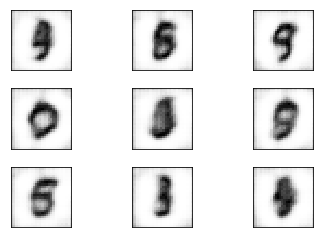

Epoach 3000
Discriminator loss:  0.94595
Generator loss: 1.72849
(9, 100)
[-0.50945717 -0.57781976 -0.76991183 -0.71781254 -0.7973389  -0.76145613
 -0.8176409  -0.77501148 -0.82976073 -0.77180278 -0.82099938 -0.7914716
 -0.82576489 -0.76519567 -0.76266921 -0.69460583 -0.73316824 -0.72815722
 -0.79835862 -0.73453635 -0.82717931 -0.79236984 -0.8531996  -0.77647203
 -0.7977367  -0.73428327 -0.78232551 -0.64510357 -0.65462434 -0.72974098
 -0.86365777 -0.85721779 -0.90089536 -0.91036224 -0.92098635 -0.92228228
 -0.93836486 -0.92951322 -0.9335016  -0.92998898 -0.92249805 -0.8682707
 -0.80500561 -0.77618682 -0.81167251 -0.85248077 -0.8908971  -0.90984333
 -0.94732773 -0.94521582 -0.95096934 -0.9285146  -0.91030949 -0.88442063
 -0.88546091 -0.79100102 -0.71510279 -0.80231893 -0.9221369  -0.92123854
 -0.95627385 -0.96341056 -0.96960121 -0.96684736 -0.97975945 -0.9717499
 -0.97709548 -0.96448338 -0.96028239 -0.86743116 -0.83926058 -0.80792892
 -0.85218579 -0.9170298  -0.95463735 -0.97396952 -0.9

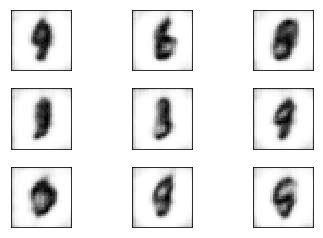

Epoach 3500
Discriminator loss:  0.406078
Generator loss: 2.78076
(9, 100)
[-0.4758676  -0.59262347 -0.7400952  -0.65662229 -0.71763813 -0.72541797
 -0.76923829 -0.7416665  -0.80386317 -0.80420256 -0.84927416 -0.88862747
 -0.92536145 -0.9219892  -0.92240608 -0.93027008 -0.92064178 -0.91028684
 -0.92586696 -0.88810265 -0.87571043 -0.8451401  -0.85796171 -0.80006403
 -0.77458584 -0.68191576 -0.70507956 -0.57559836 -0.62282127 -0.72997296
 -0.83764946 -0.82430303 -0.87106395 -0.89193398 -0.90481675 -0.92346752
 -0.94648832 -0.95442337 -0.96469486 -0.98065871 -0.98577178 -0.98183924
 -0.97047496 -0.97937483 -0.9822309  -0.97502422 -0.96897811 -0.96759695
 -0.97124863 -0.96546161 -0.95872211 -0.93830884 -0.89987886 -0.86255389
 -0.79917443 -0.69342858 -0.72064149 -0.79157865 -0.90142554 -0.8950851
 -0.93099749 -0.9552694  -0.96562636 -0.97508425 -0.98696715 -0.98674977
 -0.99134499 -0.99228179 -0.99455112 -0.98700643 -0.98830336 -0.98840481
 -0.98927796 -0.98141503 -0.98317552 -0.98418248 -

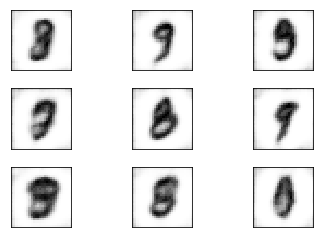

In [ ]:
lr=0.001
with tf.name_scope("discriminator_train"):
    d_optimizer = tf.train.AdamOptimizer(learning_rate=1e-4,beta1=0.1)
    d_train_op = d_optimizer.minimize(d_loss, var_list=discriminator_variables) # note minimizing negative loss is the same as maximizing, tf dont have maximizing

with tf.name_scope("generator_train"):
    g_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4,beta1=0.3)
    g_train_op = g_optimizer.minimize(g_loss,var_list=generator_variables)


## Start graph computations and algorithm

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(epoach+1):
    x_train,y_train = mnist.train.next_batch(batch_size)
    
    #print(y_one_hot)
    #first discriminator
    _, d_loss_value = sess.run([d_train_op, d_loss], feed_dict={X: x_train, isTraining:True , Z: ut.random_Z(batch_size,n=z_dimention)})
    #second generator
    _, g_loss_value = sess.run([g_train_op, g_loss], feed_dict={Z: ut.random_Z(batch_size,n=z_dimention),isTraining:True})

    if i%500 == 0:
        print("Epoach",i)
        print("Discriminator loss: ",d_loss_value)
        print("Generator loss:",g_loss_value)
        #print("D_sample",d_sample)
        #print("G_sample",g_sample)
        
        #visual progress of training
        z_new = ut.random_Z(9,n=z_dimention)
        print(z_new.shape)
        generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new}).reshape((9,784))

        ut.plot_mnist_images(remap)

### Testing the classifier

In [ ]:
sess.close()